## Description
Utilizing the dataset available on [http://archive.ics.uci.edu/dataset/34/diabetes], we intend to perform comprehensive patient phenotyping for individuals with diabetes. The goal is to extract valuable insights and categorize patients based on their unique clinical characteristics, including but not limited to vitals, eating behaviours, and treatment. 



We'll proceed step by step, beginning with the **README-DIABETES** file, which contains information about the dataset.
The README-DIABETES file indicates that the dataset consists of records for outpatient care on 70 patients with diabetes and is intended for use in medical research. It also mentions two other files: <br>
**Data-Codes:** This file contains a listing of the codes used in the datasets. <br>
**Domain-Description:** This file describes the basic physiology and pathophysiology of diabetes mellitus; a metabolic disease, involving inappropriately elevated blood glucose levels, and its treatment.

**33** = Regular insulin dose  
**34** = NPH insulin dose  
**35** = UltraLente insulin dose  
**48** = Unspecified blood glucose measurement  
**57** = Unspecified blood glucose measurement  
**58** = Pre-breakfast blood glucose measurement  
**59** = Post-breakfast blood glucose measurement  
**60** = Pre-lunch blood glucose measurement  
**61** = Post-lunch blood glucose measurement  
**62** = Pre-supper blood glucose measurement  
**63** = Post-supper blood glucose measurement  
**64** = Pre-snack blood glucose measurement  
**65** = Hypoglycemic symptoms  
**66** = Typical meal ingestion  
**67** = More-than-usual meal ingestion  
**68** = Less-than-usual meal ingestion  
**69** = Typical exercise activity  
**70** = More-than-usual exercise activity  
**71** = Less-than-usual exercise activity  
**72** = Unspecified special event

# Our aim is to cluster the patients and categorize them into different groups; this can facilitate personalized suggestions for managing their blood glucose (BG) levels

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans
import seaborn as sns


data_directory = " INPUT DATA DIRECTORY HERE"

# List all files in the directory
all_files = os.listdir(data_directory)

# Filter out files that match the format 'data-XX'
data_files = [file for file in all_files if file.startswith('data-') and file[5:7].isdigit()]

# Print the list of data files
print(data_files)



def load_patient_data(files_list, directory):
    data_frames = []
    for file_name in files_list:
        # Construct the full file path
        file_path = f'{directory}/{file_name}'
        # Extract the patient ID from the filename assuming the format 'data-XX'
        patient_id = file_name.split('-')[1].split('.')[0]  # Removes file extension if present
        # Read the data file, assuming it's a text file with tab-separated values
        df = pd.read_csv(file_path, sep='\t', names=['Date', 'Time', 'Code', 'Value'])
        # Add a column for the patient ID
        df['Patient_ID'] = patient_id
        # Append the dataframe to the list
        data_frames.append(df)
    # Concatenate all dataframes into a single dataframe
    return pd.concat(data_frames, ignore_index=True)

patient_data = load_patient_data(data_files,data_directory)

# Inspect data
print(patient_data.head())
print(patient_data.info())




['data-01', 'data-02', 'data-03', 'data-04', 'data-05', 'data-06', 'data-07', 'data-08', 'data-09', 'data-10', 'data-11', 'data-12', 'data-13', 'data-14', 'data-15', 'data-16', 'data-17', 'data-18', 'data-19', 'data-20', 'data-21', 'data-22', 'data-23', 'data-24', 'data-25', 'data-26', 'data-27', 'data-28', 'data-29', 'data-30', 'data-31', 'data-32', 'data-33', 'data-34', 'data-35', 'data-36', 'data-37', 'data-38', 'data-39', 'data-40', 'data-41', 'data-42', 'data-43', 'data-44', 'data-45', 'data-46', 'data-47', 'data-48', 'data-49', 'data-50', 'data-51', 'data-52', 'data-53', 'data-54', 'data-55', 'data-56', 'data-57', 'data-58', 'data-59', 'data-60', 'data-61', 'data-62', 'data-63', 'data-64', 'data-65', 'data-66', 'data-67', 'data-68', 'data-69', 'data-70']
         Date   Time  Code Value Patient_ID
0  04-21-1991   9:09    58   100         01
1  04-21-1991   9:09    33     9         01
2  04-21-1991   9:09    34    13         01
3  04-21-1991  17:08    62   119         01
4  04-21-

## Handling invalid values in the dataset

First, we need to clean the data and check for any invalid/ missing values including in Date, Time, or Code

In [200]:
# Convert 'Date' and 'Time' to datetime, and create a new 'Timestamp' column
patient_data['Timestamp'] = pd.to_datetime(patient_data['Date'] + ' ' + patient_data['Time'], errors='coerce')

# Check for any rows where the datetime conversion failed
invalid_datetime = patient_data[patient_data['Timestamp'].isnull()]

# Remove rows with invalid datetime
patient_data_cleaned = patient_data.dropna(subset=['Timestamp'])

print(f"Invalid datetime entries:\n{invalid_datetime}")
print(f"Cleaned data shape: {patient_data_cleaned.shape}")

################################ Next, check for missmatch code values 

# List of valid codes
valid_codes = [33, 34, 35, 48, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]

# Check for rows with codes that don't match the valid codes
invalid_code_rows = patient_data_cleaned[~patient_data_cleaned['Code'].isin(valid_codes)]

# Find and print the unique invalid codes - Unique invalid codes found: [56  4 36  0]
unique_invalid_codes = invalid_code_rows['Code'].unique()
print(f"Unique invalid codes: {unique_invalid_codes}")

# Get and print the frequency of each unique invalid code - corresponding frequency: [119 1 1 33]
invalid_code_counts = invalid_code_rows['Code'].value_counts()
print(invalid_code_counts)

# Keep only rows where 'Code' is in the list of valid codes
patient_data_cleaned = patient_data_cleaned[patient_data_cleaned['Code'].isin(valid_codes)]

# Next, check for non-numeric values in 'Code' column and display them
non_numeric_codes = patient_data_cleaned[pd.to_numeric(patient_data_cleaned['Code'], errors='ignore').apply(lambda x: not str(x).isdigit())]


############################### Check for non-numeric values in 'Value' column and drop them
non_numeric_values = patient_data_cleaned[pd.to_numeric(patient_data_cleaned['Value'], errors='ignore').apply(lambda x: not str(x).replace('.', '', 1).isdigit())]

# Display non-numeric entries for 'Code' and 'Value' for quality check
if not non_numeric_codes.empty:
    print("Non-numeric Codes:")
    print(non_numeric_codes)

if not non_numeric_values.empty:
    print("\nNon-numeric Values:")
    print(non_numeric_values)

# Here we observed 8 instances of "Hi" and "Lo" instead of numerical values , and will drop them from the dataframe 
    
# Convert 'Code' and 'Value' to numeric, invalid parsing will be set as NaN
patient_data_cleaned['Code'] = pd.to_numeric(patient_data_cleaned['Code'], errors='coerce')
patient_data_cleaned['Value'] = pd.to_numeric(patient_data_cleaned['Value'], errors='coerce')

# Drop rows where 'Code' or 'Value' are NaN
patient_data_cleaned = patient_data_cleaned.dropna(subset=['Code', 'Value'])

# Print the shape of the final cleaned data and the original data
print(f"Original data shape: {patient_data.shape}")
print(f"Cleaned data shape after cleaning: {patient_data_cleaned.shape}")



Invalid datetime entries:
             Date    Time  Code Value Patient_ID Timestamp
6505   06-31-1991   07:50    58   149         20       NaT
6506   06-31-1991   07:50    33     4         20       NaT
6507   06-31-1991   07:50    34    24         20       NaT
6508   06-31-1991   13:30    60   162         20       NaT
6509   06-31-1991   13:30    33     5         20       NaT
6510   06-31-1991   19:45    62   213         20       NaT
6511   06-31-1991   19:45    33    11         20       NaT
9961          NaN     138    33    3A         27       NaT
9963          NaN     006    33    21         27       NaT
9965          NaN     016    33    22         27       NaT
11240         NaN     201    33    3A         29       NaT
11242         NaN     004    33    21         29       NaT
11244         NaN     018    33    22         29       NaT
11466         NaN     202    33    3A         29       NaT
11468         NaN     006    33    21         29       NaT
11470         NaN     018    3

In [201]:
#add a new column Record_Type to patient_data_cleaned, categorizing each row as either Electronic or Paper based on the time field

# Define fixed times for paper records
fixed_times = ['08:00', '12:00', '18:00', '22:00']


# Flag records as 'Electronic' or 'Paper' based on the time field
patient_data_cleaned['Record_Type'] = patient_data_cleaned['Time'].apply(lambda x: 'Paper' if x in fixed_times else 'Electronic')

# Count the number of records in each group
record_type_counts = patient_data_cleaned['Record_Type'].value_counts()

# Print the counts
print("Record Type Stats")
print(record_type_counts)


Record Type Stats
Electronic    19432
Paper          9691
Name: Record_Type, dtype: int64


In [54]:
# Save the cleaned patient data to a CSV file in the data directory
patient_data_cleaned.to_csv(' PATH TO SAVE FILE', index=False)


The count indicates that, **after cleaning**, we have **19,432 electronic records** and **9,691 paper records**. With this distinction, we can now proceed with separate analyses that account for the different nature of these records.
_*For example, if we're analyzing trends over time, we might want to use only electronic records to get precise timestamps. Alternatively, if we're looking at general patterns like the number of events per day, paper records could still be useful despite their approximate times.*_

Now that cleaning is done, we can move on to the the exploratory data analysis (EDA) and phenotyping. 

# Exploratory Data Analysis phase 1 
### Descriptive Statistics 

In [202]:
# Filter the dataframe to exclude non-numeric 'Value' entries and convert to float
numeric_data = patient_data_cleaned[pd.to_numeric(patient_data_cleaned['Value'], errors='coerce').notnull()]
numeric_data['Value'] = numeric_data['Value'].astype(float)

# Group the data by 'Code' and calculate descriptive statistics for the 'Value' column
descriptive_stats = numeric_data.groupby('Code')['Value'].describe()

# Print the descriptive statistics
print(descriptive_stats)

# Define a function to calculate the outliers based on IQR
def calculate_outliers(row):
    IQR = row['75%'] - row['25%']
    lower_bound = row['25%'] - 1.5 * IQR
    upper_bound = row['75%'] + 1.5 * IQR
    return lower_bound, upper_bound, row['min'] < lower_bound or row['max'] > upper_bound

# Apply the function to each row in the descriptive statistics dataframe
descriptive_stats[['Lower_Bound', 'Upper_Bound', 'Has_Outliers']] = descriptive_stats.apply(calculate_outliers, axis=1, result_type='expand')

# Print out the rows with outliers
print(descriptive_stats[descriptive_stats['Has_Outliers']])
print("This table shows which code values have outliers")


       count        mean         std   min     25%    50%     75%    max
Code                                                                    
33    9480.0    6.614662    5.417712   0.0    4.00    6.0    9.00  344.0
34    3828.0   15.384927   14.152530   1.0    7.00   15.0   20.00  388.0
35    1053.0   15.858500    7.808906   3.0   10.00   15.0   21.00   30.0
48    1881.0  171.123339   78.570349  28.0  113.00  160.0  209.00  487.0
57     989.0  160.286148   98.904843  19.0   75.00  142.0  227.00  501.0
58    3516.0  170.682878   77.750386  23.0  107.75  161.0  223.00  461.0
59      20.0  178.350000   81.883277  49.0   87.00  190.5  230.00  339.0
60    2767.0  143.557282   74.571266  15.0   85.00  134.0  187.00  452.0
61      66.0  244.515152  104.364633  25.0  177.00  225.0  303.50  476.0
62    3156.0  156.368504   74.114736  28.0   99.00  147.0  201.00  450.0
63     219.0  186.150685   92.158122  37.0  104.00  183.0  257.00  413.0
64     904.0  148.772124   86.731948   0.0   80.00 

In [212]:
# 'patient_data_cleaned' is the original cleaned dataframe and 'descriptive_stats' contains the IQR stats.

# Define a function to filter out the outliers for a given 'Code'
def remove_outliers(dataframe, code, lower_bound, upper_bound):
    # Get only the rows for this 'Code'
    code_data = dataframe[dataframe['Code'] == code]
    # Filter out the outliers
    filtered_code_data = code_data[(code_data['Value'] >= lower_bound) & (code_data['Value'] <= upper_bound)]
    return filtered_code_data

# Create an empty dataframe to hold the data without outliers
data_without_outliers = pd.DataFrame(columns=patient_data_cleaned.columns)

# Loop over each 'Code' in 'descriptive_stats' and remove outliers
for index, row in descriptive_stats.iterrows():
    if row['Has_Outliers']:
        # Remove outliers for this 'Code'
        cleaned_data = remove_outliers(patient_data_cleaned, index, row['Lower_Bound'], row['Upper_Bound'])
        # Append the cleaned data to the dataframe
        data_without_outliers = data_without_outliers.append(cleaned_data, ignore_index=True)
    else:
        # If there are no outliers, just append the data as is
        data_without_outliers = data_without_outliers.append(patient_data_cleaned[patient_data_cleaned['Code'] == index], ignore_index=True)

# Now 'data_without_outliers' contains the data with outliers removed


C:\Users\Faranak\AppData\Local\Temp\ipykernel_788\3624725697.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_without_outliers = data_without_outliers.append(cleaned_data, ignore_index=True)
C:\Users\Faranak\AppData\Local\Temp\ipykernel_788\3624725697.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_without_outliers = data_without_outliers.append(patient_data_cleaned[patient_data_cleaned['Code'] == index], ignore_index=True)


In [204]:
np.shape(data_without_outliers)

(28574, 7)

## EDA Phase 2: Preparing features 

In [233]:
import pandas as pd
from pandas import DataFrame

# Assuming patient_data_cleaned is already defined and loaded as a DataFrame.

patient_data_cleaned=data_without_outliers

# Define the codes for insulin, BG measurements, meals, exercise, hypoglycemia, and special events
INSULIN_CODES = {'Regular_insulin': 33, 'NPH_insulin': 34, 'UltraLente_insulin': 35}
BG_MEASUREMENT_CODES = {
    'Pre_breakfast': 58, 'Post_breakfast': 59, 'Pre_lunch': 60, 
    'Post_lunch': 61, 'Pre_supper': 62, 'Post_supper': 63, 
    'Pre_snack': 64, 'Unspecified_BG': [48, 57]  # Including unspecified BG codes
}
MEAL_CODES = {'Typical_meal': 66, 'More_than_usual_meal': 67, 'Less_than_usual_meal': 68}
EXERCISE_CODES = {'Typical_exercise': 69, 'More_than_usual_exercise': 70, 'Less_than_usual_exercise': 71}
HYPOGLYCEMIC_SYMPTOMS_CODE = 65
SPECIAL_EVENT_CODE = 72

# Filter the dataframe to include only the relevant 'Code' values
codes = list(INSULIN_CODES.values()) + \
        [code for sublist in BG_MEASUREMENT_CODES.values() for code in (sublist if isinstance(sublist, list) else [sublist])] + \
        list(MEAL_CODES.values()) + \
        list(EXERCISE_CODES.values()) + \
        [HYPOGLYCEMIC_SYMPTOMS_CODE, SPECIAL_EVENT_CODE]
filtered_data = patient_data_cleaned[patient_data_cleaned['Code'].isin(codes)]

# Convert 'Value' to numeric, forcing non-numeric values to NaN and then filtering them out
filtered_data['Value'] = pd.to_numeric(filtered_data['Value'], errors='coerce')
filtered_data.dropna(subset=['Value'], inplace=True)

# Initialize a DataFrame to store features
patient_features = pd.DataFrame(index=pd.MultiIndex.from_product([filtered_data['Patient_ID'].unique(), 
                                                              filtered_data['Date'].unique()], names=['Patient_ID', 'Date']))

# # Insulin features: total daily dose for each type of insulin, fill NaN with 0
# for insulin, code in INSULIN_CODES.items():
#     daily_doses = filtered_data[filtered_data['Code'] == code].groupby(['Patient_ID', 'Date'])['Value'].sum()
#     daily_doses = daily_doses.reindex(patient_features.index, fill_value=0)
#     patient_features[insulin] = daily_doses

# Insulin features: total daily dose for each type of insulin
for insulin, code in INSULIN_CODES.items():
    daily_doses = filtered_data[filtered_data['Code'] == code].groupby(['Patient_ID', 'Date'])['Value'].sum()
    patient_features[insulin] = daily_doses    
    

# Blood glucose features: average BG readings at different times of the day, fill NaN with median
# First, calculate the median BG value for each patient across all days
median_bg_per_patient = filtered_data[filtered_data['Code'].isin([code for codes in BG_MEASUREMENT_CODES.values() for code in (codes if isinstance(codes, list) else [codes])])].groupby('Patient_ID')['Value'].median()

# Now iterate over each BG measurement feature
for time, codes in BG_MEASUREMENT_CODES.items():
    if not isinstance(codes, list):
        codes = [codes]
    bg_mean = filtered_data[filtered_data['Code'].isin(codes)].groupby(['Patient_ID', 'Date'])['Value'].mean()
    bg_mean = bg_mean.unstack(fill_value=0)  # unstack and fill with 0 temporarily

    # Instead of reindexing, we use .loc to ensure the indices match
    for patient_id in median_bg_per_patient.index:
        # Use .loc to align indices and then fill NaNs with the patient's median BG
        if patient_id in bg_mean.index:
            patient_features.loc[(patient_id, slice(None)), time + '_BG_mean'] = bg_mean.loc[patient_id].fillna(median_bg_per_patient[patient_id])
        else:
            # If the patient_id is not in bg_mean, we fill with the patient's median BG
            patient_features.loc[(patient_id, slice(None)), time + '_BG_mean'] = median_bg_per_patient[patient_id]

# Meal features: count of meal ingestion types, fill NaN with 0
for meal, code in MEAL_CODES.items():
    meal_counts = filtered_data[filtered_data['Code'] == code].groupby(['Patient_ID', 'Date'])['Value'].count()
    meal_counts = meal_counts.reindex(patient_features.index, fill_value=0)
    patient_features[meal] = meal_counts

# Exercise features: count of exercise activities, fill NaN with 0
for exercise, code in EXERCISE_CODES.items():
    exercise_counts = filtered_data[filtered_data['Code'] == code].groupby(['Patient_ID', 'Date'])['Value'].count()
    # Reindex to match patient_features index and fill NaN with 0
    exercise_counts = exercise_counts.reindex(patient_features.index, fill_value=0)
    patient_features[exercise] = exercise_counts

# Hypoglycemic event features: count of hypoglycemic symptoms experienced
# Assuming hypoglycemic_events is indexed by ('Patient_ID', 'Date') after groupby
hypoglycemic_events = filtered_data[filtered_data['Code'] == HYPOGLYCEMIC_SYMPTOMS_CODE].groupby(['Patient_ID', 'Date'])['Value'].count()

# Re-index to match patient_features index and fill NaN with 0
hypoglycemic_events = hypoglycemic_events.reindex(patient_features.index, fill_value=0)

# Since patient_features expects a Series for a single column assignment, make sure hypoglycemic_events is a Series
# If hypoglycemic_events is a DataFrame with one column per date, sum across the dates to collapse into a single column
if isinstance(hypoglycemic_events, pd.DataFrame):
    hypoglycemic_events = hypoglycemic_events.sum(axis=1)

# Now assign this single series to the patient_features DataFrame
patient_features['Hypoglycemic_events'] = hypoglycemic_events

# Assuming special_events is indexed by ('Patient_ID', 'Date') after groupby
special_events = filtered_data[filtered_data['Code'] == SPECIAL_EVENT_CODE].groupby(['Patient_ID', 'Date'])['Value'].count()

# Re-index to match patient_features index and fill NaN with 0
special_events = special_events.reindex(patient_features.index, fill_value=0)

# Now assign this single series to the patient_features DataFrame
patient_features['Special_events'] = special_events


# Aggregate features by patient across all dates
patient_aggregated_features = patient_features.groupby('Patient_ID').mean()




In [234]:
patient_features

Regular_insulin  NPH_insulin  UltraLente_insulin  \
Patient_ID Date                                                           
01         04-21-1991             16.0         13.0                 NaN   
           04-22-1991             19.0         13.0                 NaN   
           04-23-1991             18.0         13.0                 NaN   
           04-24-1991             19.0         14.0                 NaN   
           04-25-1991             22.0         14.0                 NaN   
...                                ...          ...                 ...   
69         01-08-1989              NaN          NaN                 NaN   
           06-25-1990              NaN          NaN                 NaN   
           06-27-1990              NaN          NaN                 NaN   
           06-28-1990              NaN          NaN                 NaN   
           06-29-1990              NaN          NaN                 NaN   

                       Pre_breakfast_BG_mean  Post_breakfast_BG_mean  \
Patient_ID Date                                                        
01         04-21-1991                    NaN                   149.0   
           04-22-1991                    NaN                   149.0   
           04-23-1991                    NaN                   149.0   
           04-24-1991                    NaN                   149.0   
           04-25-1991                    NaN                   149.0   
...                                      ...                     ...   
69         01-08-1989                  184.0                   184.0   
           06-25-1990                  184.0                   184.0   
           06-27-1990                  184.0                   184.0   
           06-28-1990                  184.0                   184.0   
           06-29-1990                  184.0                   184.0   

                       Pre_lunch_BG_mean  Post_lunch_BG_mean  \
Patient_ID Date                                                
01         04-21-1991                NaN               149.0   
           04-22-1991                NaN               149.0   
           04-23-1991                NaN               149.0   
           04-24-1991                NaN               149.0   
           04-25-1991                NaN               149.0   
...                                  ...                 ...   
69         01-08-1989              184.0               184.0   
           06-25-1990              184.0               184.0   
           06-27-1990              184.0               184.0   
           06-28-1990              184.0               184.0   
           06-29-1990              184.0               184.0   

                       Pre_supper_BG_mean  Post_supper_BG_mean  \
Patient_ID Date                                                  
01         04-21-1991                 NaN                149.0   
           04-22-1991                 NaN                149.0   
           04-23-1991                 NaN                149.0   
           04-24-1991                 NaN                149.0   
           04-25-1991                 NaN                149.0   
...                                   ...                  ...   
69         01-08-1989               184.0                  NaN   
           06-25-1990               184.0                  NaN   
           06-27-1990               184.0                  NaN   
           06-28-1990               184.0                  NaN   
           06-29-1990               184.0                  NaN   

                       Pre_snack_BG_mean  Unspecified_BG_BG_mean  \
Patient_ID Date                                                    
01         04-21-1991              149.0                     NaN   
           04-22-1991              149.0                     NaN   
           04-23-1991              149.0                     NaN   
           04-24-1991              149.0                     NaN   
          

In [235]:
patient_aggregated_features

,Regular_insulin,NPH_insulin,UltraLente_insulin,Pre_breakfast_BG_mean,Post_breakfast_BG_mean,Pre_lunch_BG_mean,Post_lunch_BG_mean,Pre_supper_BG_mean,Post_supper_BG_mean,Pre_snack_BG_mean,Unspecified_BG_BG_mean,Typical_meal,More_than_usual_meal,Less_than_usual_meal,Typical_exercise,More_than_usual_exercise,Less_than_usual_exercise,Hypoglycemic_events,Special_events
Patient_ID,,,,,,,,,,,,,,,,,,,
01,18.617647,15.375000,NaN,NaN,149.0,NaN,149.0,NaN,149.0,149.0,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.044737,0.000000
02,38.114583,11.333333,NaN,NaN,191.0,NaN,191.0,NaN,191.0,191.0,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
03,3.743590,8.000000,15.820513,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.008772,0.0,0.0,0.0,0.0,0.002632,0.003509
04,4.184211,16.266667,15.200000,NaN,158.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.005263,0.0,0.0,0.0,0.0,0.000877,0.000877
05,4.195122,15.756098,NaN,NaN,157.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.001754,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,29.850000,NaN,26.000000,216.0,216.0,216.0,216.0,216.0,216.0,216.0,NaN,0.061404,0.000000,0.0,0.0,0.0,0.0,0.003509,0.000000
67,28.793103,NaN,NaN,NaN,NaN,NaN,191.5,NaN,191.5,191.5,NaN,0.000000,0.007895,0.0,0.0,0.0,0.0,0.015789,0.000000
68,NaN,14.084337,NaN,NaN,119.0,NaN,119.0,NaN,119.0,119.0,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


## Handling Missing Data
As we can see in the aggregated feature data, some measurements are unavailable for some of the patients. Applying k-means clustering would not be possible before handling the missing values first. One approach is to impute missing values using mean or median. Since there are multiple outliers in the data and distribution is skewed, **median** would be a better choice. 

In [236]:
# Define the insulin columns based on the INSULIN_CODES keys
insulin_columns = list(INSULIN_CODES.keys())

# Replace NaN values with 0 for the insulin columns
patient_aggregated_features[insulin_columns] = patient_aggregated_features[insulin_columns].fillna(0)

# Now, the insulin levels in patient_aggregated_features should have NaN replaced with 0

# Fill any remaining NaN values that might exist if a patient had no BG measurements at all
patient_aggregated_features.fillna(patient_aggregated_features.median(), inplace=True)

# The patient_aggregated_features DataFrame now contains the mean aggregated feature set for each patient.

In [237]:
patient_aggregated_features

,Regular_insulin,NPH_insulin,UltraLente_insulin,Pre_breakfast_BG_mean,Post_breakfast_BG_mean,Pre_lunch_BG_mean,Post_lunch_BG_mean,Pre_supper_BG_mean,Post_supper_BG_mean,Pre_snack_BG_mean,Unspecified_BG_BG_mean,Typical_meal,More_than_usual_meal,Less_than_usual_meal,Typical_exercise,More_than_usual_exercise,Less_than_usual_exercise,Hypoglycemic_events,Special_events
Patient_ID,,,,,,,,,,,,,,,,,,,
01,18.617647,15.375000,0.000000,147.5,149.00,164.0,149.0,147.5,149.0,149.0,146.5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.044737,0.000000
02,38.114583,11.333333,0.000000,147.5,191.00,164.0,191.0,147.5,191.0,191.0,146.5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
03,3.743590,8.000000,15.820513,147.5,124.00,164.0,149.0,147.5,146.5,157.5,146.5,0.000000,0.008772,0.0,0.0,0.0,0.0,0.002632,0.003509
04,4.184211,16.266667,15.200000,147.5,158.00,164.0,149.0,147.5,146.5,157.5,146.5,0.000000,0.005263,0.0,0.0,0.0,0.0,0.000877,0.000877
05,4.195122,15.756098,0.000000,147.5,157.00,164.0,149.0,147.5,146.5,157.5,146.5,0.000000,0.001754,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,29.850000,0.000000,26.000000,216.0,216.00,216.0,216.0,216.0,216.0,216.0,146.5,0.061404,0.000000,0.0,0.0,0.0,0.0,0.003509,0.000000
67,28.793103,0.000000,0.000000,147.5,150.75,164.0,191.5,147.5,191.5,191.5,146.5,0.000000,0.007895,0.0,0.0,0.0,0.0,0.015789,0.000000
68,0.000000,14.084337,0.000000,147.5,119.00,164.0,119.0,147.5,119.0,119.0,146.5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


Now let's use standardization on the aggregated features to ensure that each feature contributes equally to the distance computation in clustering.

In [239]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Select all columns to standardize (assuming all are numeric features and there's no 'Patient_ID' column)
features_to_standardize = patient_aggregated_features.columns.tolist()

# Fit the scaler to the features and transform them
patient_aggregated_features_scaled = scaler.fit_transform(patient_aggregated_features[features_to_standardize])

# Create a new DataFrame with the standardized values
patient_aggregated_features_standardized = pd.DataFrame(patient_aggregated_features_scaled, columns=features_to_standardize, index=patient_aggregated_features.index)

# Now patient_aggregated_features_standardized has all standardized features ready for clustering


In [240]:
patient_aggregated_features_standardized

,Regular_insulin,NPH_insulin,UltraLente_insulin,Pre_breakfast_BG_mean,Post_breakfast_BG_mean,Pre_lunch_BG_mean,Post_lunch_BG_mean,Pre_supper_BG_mean,Post_supper_BG_mean,Pre_snack_BG_mean,Unspecified_BG_BG_mean,Typical_meal,More_than_usual_meal,Less_than_usual_meal,Typical_exercise,More_than_usual_exercise,Less_than_usual_exercise,Hypoglycemic_events,Special_events
Patient_ID,,,,,,,,,,,,,,,,,,,
01,0.487061,0.038050,-0.564303,-0.027219,-0.140115,0.074707,-0.000281,-0.027219,0.030000,-0.511361,-0.076118,-0.231511,-0.709763,-0.474055,-0.43201,-0.458147,-0.420806,5.650640,-0.567626
02,2.659009,-0.316260,-0.564303,-0.027219,1.374365,0.074707,1.652758,-0.027219,1.848548,1.824928,-0.076118,-0.231511,-0.709763,-0.474055,-0.43201,-0.458147,-0.420806,-0.577450,-0.567626
03,-1.169901,-0.608474,1.206338,-0.027219,-1.041591,0.074707,-0.000281,-0.027219,-0.078247,-0.038541,-0.076118,-0.231511,0.814268,-0.474055,-0.43201,-0.458147,-0.420806,-0.211092,1.123175
04,-1.120816,0.116217,1.136890,-0.027219,0.184416,0.074707,-0.000281,-0.027219,-0.078247,-0.038541,-0.076118,-0.231511,0.204656,-0.474055,-0.43201,-0.458147,-0.420806,-0.455331,-0.144926
05,-1.119601,0.071459,-0.564303,-0.027219,0.148357,0.074707,-0.000281,-0.027219,-0.078247,-0.038541,-0.076118,-0.231511,-0.404957,-0.474055,-0.43201,-0.458147,-0.420806,-0.577450,-0.567626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,1.738339,-1.309789,2.345633,5.647452,2.275841,4.569468,2.636710,5.647452,2.931017,3.215576,-0.076118,7.134753,-0.709763,-0.474055,-0.43201,-0.458147,-0.420806,-0.088973,-0.567626
67,1.620601,-1.309789,-0.564303,-0.027219,-0.077012,0.074707,1.672437,-0.027219,1.870198,1.852741,-0.076118,-0.231511,0.661865,-0.474055,-0.43201,-0.458147,-0.420806,1.620699,-0.567626
68,-1.586935,-0.075095,-0.564303,-0.027219,-1.221887,0.074707,-1.181023,-0.027219,-1.268963,-2.180139,-0.076118,-0.231511,-0.709763,-0.474055,-0.43201,-0.458147,-0.420806,-0.577450,-0.567626


In [241]:
features_to_standardize

['Regular_insulin',
 'NPH_insulin',
 'UltraLente_insulin',
 'Pre_breakfast_BG_mean',
 'Post_breakfast_BG_mean',
 'Pre_lunch_BG_mean',
 'Post_lunch_BG_mean',
 'Pre_supper_BG_mean',
 'Post_supper_BG_mean',
 'Pre_snack_BG_mean',
 'Unspecified_BG_BG_mean',
 'Typical_meal',
 'More_than_usual_meal',
 'Less_than_usual_meal',
 'Typical_exercise',
 'More_than_usual_exercise',
 'Less_than_usual_exercise',
 'Hypoglycemic_events',
 'Special_events']

Now, let's do clustering and interpretation

C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when t

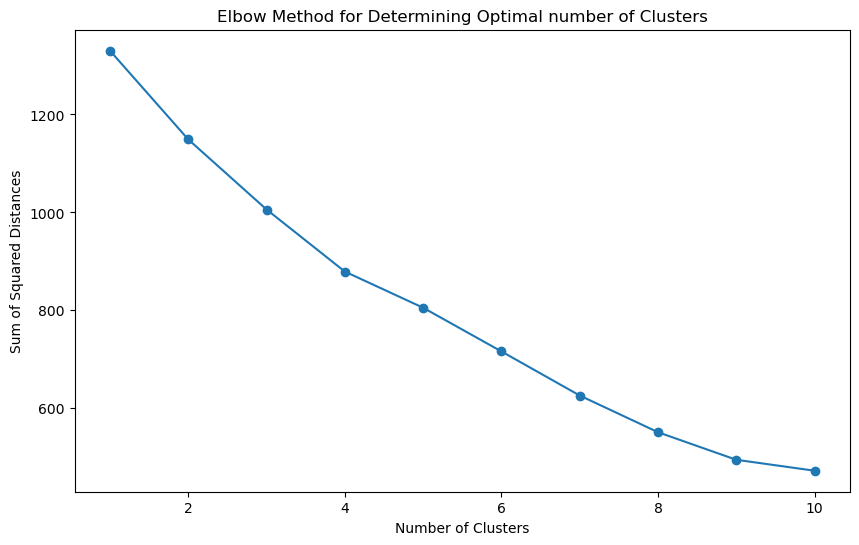

In [242]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate sum of squared distances
sse = []
for k in range(1, 11):  # Adjust the range of k as needed
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(patient_aggregated_features_standardized)
    sse.append(kmeans.inertia_)

# Plot SSE for each *k*
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()


C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


   Regular_insulin  NPH_insulin  UltraLente_insulin  Pre_breakfast_BG_mean  \
0        -0.326554     0.226621           -0.194993              -0.267461   
1         1.738339    -1.309789            2.345633               5.647452   
2         0.618301    -0.730896            0.422635               0.230511   
3        -0.089897     0.408388           -0.195519              -0.027219   

   Post_breakfast_BG_mean  Pre_lunch_BG_mean  Post_lunch_BG_mean  \
0               -0.567415          -0.210538           -0.572660   
1                2.275841           4.569468            2.636710   
2                0.891074           0.185155            0.910421   
3                0.096522          -0.033340            0.063676   

   Pre_supper_BG_mean  Post_supper_BG_mean  Pre_snack_BG_mean  \
0           -0.267461            -0.533503          -0.493879   
1            5.647452             2.931017           3.215576   
2            0.230511             0.946490           0.842203   
3       

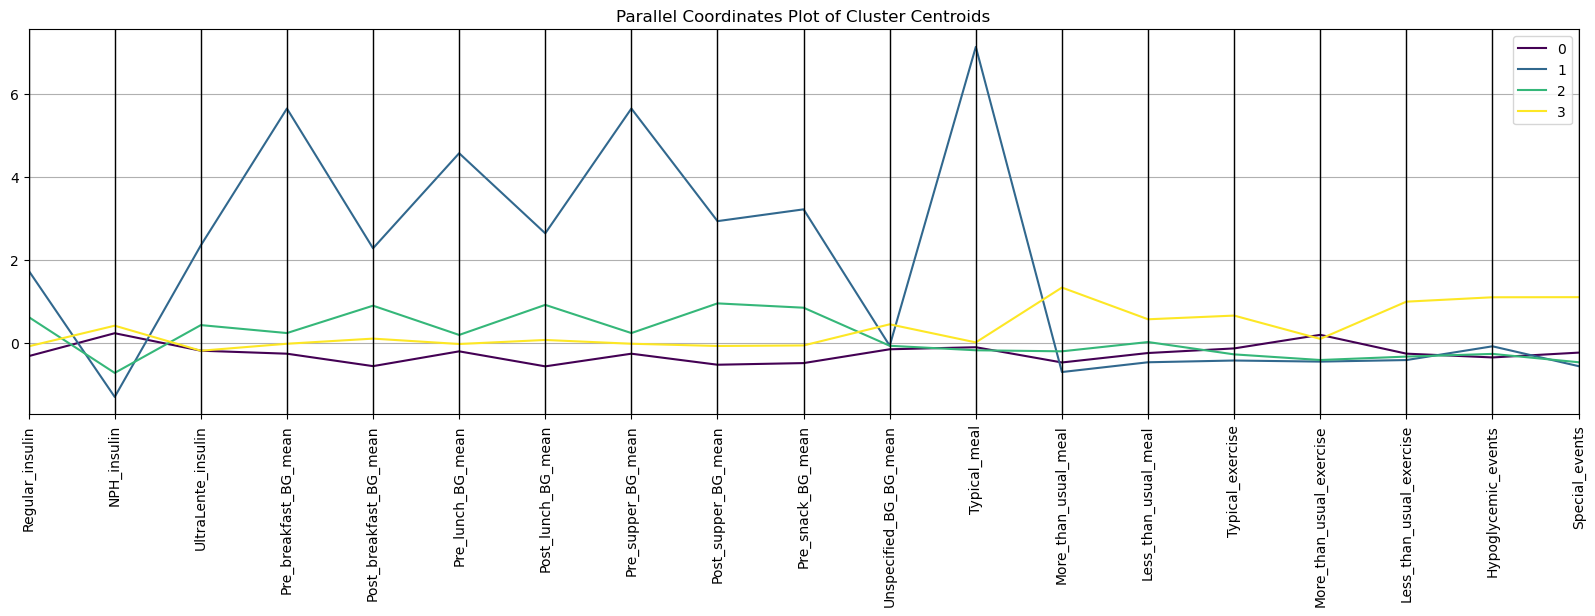

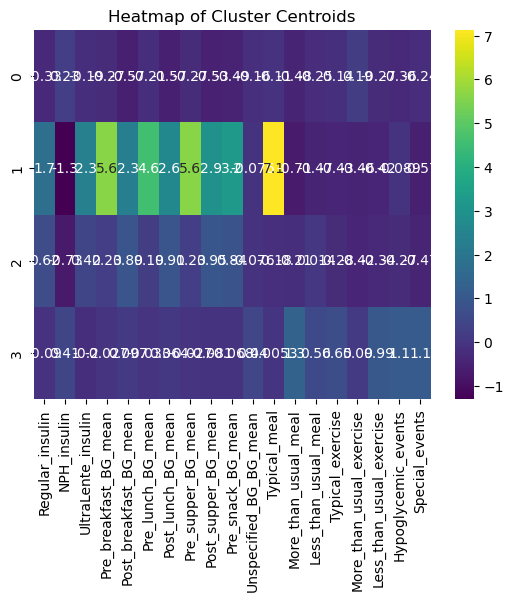

In [243]:
optimal_clusters = 4  # This is determined based on the Elbow method based on the above graph
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(patient_aggregated_features_standardized)

# Assign the cluster labels to the original dataframe
patient_aggregated_features['Cluster'] = kmeans.labels_

# Calculate the centroid of each cluster
centroids = kmeans.cluster_centers_

# Convert to a DataFrame for easier analysis
centroid_df = pd.DataFrame(centroids, columns=features_to_standardize)

# Print the centroids to see the defining characteristics
print(centroid_df)

# Parallel Coordinates Plot to visualize centroids and investigate how they differ from each other
from pandas.plotting import parallel_coordinates

# Add a cluster column to the centroids dataframe
centroid_df['Cluster'] = range(len(centroid_df))

plt.figure(figsize=(20, 5))  # Increase figure size
parallel_coordinates(centroid_df, 'Cluster', colormap='viridis')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.title('Parallel Coordinates Plot of Cluster Centroids')
plt.show()


# Heatmap of the centroids
sns.heatmap(centroid_df.iloc[:, :-1], annot=True, cmap='viridis')  # Exclude the 'Cluster' column
plt.title('Heatmap of Cluster Centroids')
plt.show()


# Clustering Interpretation and Suggested Patient Categorization

Here's a more detailed interpretation and suggested labeling of all 4 clusters based on the standardized centroid features:

- **Cluster 0: Conservative Management** <br>
**Insulin Use**: Slightly reduced use of Regular insulin and relatively standard use of NPH insulin, with lesser use of UltraLente insulin. <br>
**BG Levels**: Generally below average BG readings across all time points, which suggests a lower risk of hyperglycemia but potentially higher risk for hypoglycemia if not monitored closely. <br>
**Lifestyle**: Slightly lower than typical meal patterns and exercise levels, with fewer special events, indicating a conservative approach to diabetes management and possibly fewer interventions or changes in routine.<br>

- **Cluster 1: Intensive Insulin and Challenging BG Control** <br>
**Insulin Use**: Higher reliance on Regular insulin and significantly less on NPH insulin, with a marked use of UltraLente insulin, which suggests an intensive insulin regimen to manage blood sugar levels. <br>
**BG Levels**: Very high BG readings, especially pre-breakfast, indicating a substantial challenge in controlling blood glucose levels, possibly due to insulin resistance or other factors. <br>
**Lifestyle**: Exceptionally higher typical meal indicators and least occurrence of special events, which may reflect a strict and intensive dietary and treatment regimen due to challenging BG control<br>

- **Cluster 2: Moderate Management** <br>
**Insulin Use**: Moderate and balanced use of Regular insulin and UltraLente insulin, with lower reliance on NPH insulin.<br>
**BG Levels**: Average to slightly above average BG readings, suggesting a moderate level of BG control.<br>
**Lifestyle**: Average meal and exercise patterns with fewer special events, which indicates a stable and moderate approach to diabetes management.<br>

- **Cluster 3: Active and Engaged Management** <br>
**Insulin Use**: Balanced use of Regular insulin with a slightly higher reliance on NPH insulin and minimal use of UltraLente insulin.<br>
**BG Levels**: Average BG levels for most time points, which may suggest effective BG management.<br>
**Lifestyle**: Slightly above-average meal sizes and the most active exercise pattern among the clusters, with a higher frequency of special events, indicating an active and engaged approach to managing diabetes, with possibly more frequent adjustments to insulin dosing and dietary intake.




## **Insights for Diabetes Management:**
**Patients in cluster 0**  This cluster represents patients who have a stable BG management routine with low insulin usage. The slightly above-average use of NPH insulin suggests reliance on an intermediate-acting insulin. These patients might have a well-managed diet and exercise routine, keeping their BG levels consistent. Education on recognizing and managing hypoglycemia should be emphasized, given their lower insulin use and BG levels. <br>

**Patients in cluster 1** Patients in this cluster may be struggling with BG control, indicated by the elevated BG readings and high insulin usage. The significant reliance on UltraLente insulin suggests an attempt to manage BG over an extended period. There may be a need for a more structured diet plan, increased physical activity, and a review of insulin administration timing and doses to avoid long-term complications. <br>

**Patients in cluster 2** This group appears to have a moderate approach to insulin usage and diet, which is reflected in their average BG readings. They might benefit from a review of meal timing and composition to improve BG control further. A slight increase in physical activity could also be beneficial. Regular monitoring for hypoglycemic events is advised, given the moderate insulin use. <br>

**Patients in cluster 3** Patients in this cluster are active with variable meal patterns, which may contribute to the higher incidence of hypoglycemic events. The above-average use of NPH insulin and active lifestyle suggest that they are at risk of exercise-induced hypoglycemia. These patients may benefit from education on balancing insulin doses with meal content and timing, especially around periods of exercise, to reduce the risk of hypoglycemia. <br>


A personalized approach tailored to the characteristics of each cluster's centroid would provide a more effective diabetes management strategy, taking into account their unique challenges and needs.


Conservative Management: Patient IDs ['03', '04', '05', '09', '17', '18', '19', '20', '21', '23', '24', '25', '26', '27', '28', '30', '31', '38', '39', '40', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '64', '68'] <br>
Intensive Insulin and Challenging BG Control: Patient IDs ['66'] <br>
Moderate Management: Patient IDs ['02', '06', '07', '10', '22', '29', '37', '41', '55', '56', '57', '61', '62', '63', '65', '67', '69', '70'] <br>
Active and Engaged Management: Patient IDs ['01', '08', '11', '12', '13', '14', '15', '16', '32', '33', '34', '35', '36', '58', '59', '60'] <br>

To assign patients to these clusters, we can use the kmeans.labels_ array that was generated by the KMeans algorithm. The following code will add a new column to the patient_aggregated_features DataFrame that indicates the cluster each patient belongs to:

In [245]:
# Assign the cluster labels to the original dataframe
patient_aggregated_features['Cluster'] = kmeans.labels_

# Assign the cluster labels
cluster_labels = {
    0: "Conservative Management",
    1: "Intensive Insulin and Challenging BG Control",
    2: "Moderate Management",
    3: "Active and Engaged Management"
}

# Map the cluster numbers to the labels
patient_aggregated_features['Cluster_Label'] = patient_aggregated_features['Cluster'].map(cluster_labels)




In [246]:
# Assuming cluster_labels is a dictionary mapping cluster numbers to labels
cluster_labels = {
    0: "Conservative Management",
    1: "Intensive Insulin and Challenging BG Control",
    2: "Moderate Management",
    3: "Active and Engaged Management"
}

# Grouping patients by cluster and printing the patient IDs for each cluster with labels
clustered_patients = patient_aggregated_features.groupby('Cluster').apply(lambda x: x.index.get_level_values('Patient_ID').tolist())
for cluster, patient_ids in clustered_patients.items():
    label = cluster_labels.get(cluster, f"Cluster {cluster}")
    print(f"{label}: Patient IDs {patient_ids}")



Conservative Management: Patient IDs ['03', '04', '05', '09', '17', '18', '19', '20', '21', '23', '24', '25', '26', '27', '28', '30', '31', '38', '39', '40', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '64', '68']
Intensive Insulin and Challenging BG Control: Patient IDs ['66']
Moderate Management: Patient IDs ['02', '06', '07', '10', '22', '29', '37', '41', '55', '56', '57', '61', '62', '63', '65', '67', '69', '70']
Active and Engaged Management: Patient IDs ['01', '08', '11', '12', '13', '14', '15', '16', '32', '33', '34', '35', '36', '58', '59', '60']


## Here, we study trends of change of High and Low values of blood glucose over time.
According to the domain description, chronic hyperglycemia over a period of several years puts a patient at risk for several kinds of
micro and macrovascular problems (e.g. retinopathy). Consequently, the
goal of therapy for IDDM is to bring the average blood glucose as close to the normal range as possible. As explained below, current therapy
makes this goal a very challenging (and often frustrating) one for most patients. One important consideration is that due to the inevitable variation of blood glucose (BG) around the mean, a lower mean will result in a higher frequency of unpleasant and sometimes dangerous low BG levels.

## Risk Stratification - pinpointing patients that might need special attention

In [247]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Ensure that 'Date' and 'Time' are combined into a datetime format and set as the index
patient_data_cleaned['Timestamp'] = pd.to_datetime(patient_data_cleaned['Date'] + ' ' + patient_data_cleaned['Time'])
patient_data_cleaned.set_index('Timestamp', inplace=True)

# Set thresholds for high and low blood glucose levels based on clinical standards
HIGH_BG_THRESHOLD = 200  # High blood glucose threshold
LOW_BG_THRESHOLD = 80    # Low blood glucose threshold

# Create subsets of the data where blood glucose levels are above or below the thresholds
df_high = patient_data_cleaned[patient_data_cleaned['Value'] >= HIGH_BG_THRESHOLD]
df_low = patient_data_cleaned[patient_data_cleaned['Value'] <= LOW_BG_THRESHOLD]

# Add an 'epoch' column to convert the datetime index to a numerical format for regression analysis
df_high['epoch'] = (df_high.index.astype(np.int64) // 10**9).astype(int)
df_low['epoch'] = (df_low.index.astype(np.int64) // 10**9).astype(int)

# Define a function to calculate the slope of blood glucose levels over time for a given patient
def findslope(df):
    # Prepare the data for linear regression
    x = df['epoch']  # Independent variable: time as epoch
    y = df['Value']  # Dependent variable: blood glucose level
    x = sm.add_constant(x)  # Adds a constant term to the predictor
    model = sm.OLS(y, x)  # Create Ordinary Least Squares (OLS) model
    results = model.fit()  # Fit the model to the data
    return results.params[1]  # Return the slope coefficient

# Function to iterate over all patients and calculate the slope for each
def getslopes(df_in):
    slopes = {}  # Dictionary to hold patient IDs and their corresponding slopes
    for patient_id in df_in['Patient_ID'].unique():  # Loop through each unique patient ID
        df = df_in[df_in['Patient_ID'] == patient_id]  # Filter data for the current patient
        if len(df) <= 1:  # If there's only one or no readings, we cannot compute a slope
            slopes[patient_id] = None
        else:  # Calculate the slope if there are at least two readings
            slopes[patient_id] = findslope(df)
    return slopes

# Get the slopes for both high and low blood glucose subsets
slopes_high = getslopes(df_high)
slopes_low = getslopes(df_low)

# Analyze the slopes to determine which patients need attention for high blood glucose levels
for patient_id, slope in slopes_high.items():
    if slope is not None and slope > 0:  # A positive slope indicates increasing blood glucose levels
        print(f'Patient ID {patient_id}: Attention required, high BG trending upwards over time.')

# Do the same for patients with low blood glucose levels
for patient_id, slope in slopes_low.items():
    if slope is not None and slope < 0:  # A negative slope indicates decreasing blood glucose levels
        print(f'Patient ID {patient_id}: Attention required, low BG trending downwards over time.')

# Check for patients where both high and low BG trends are concerning
for patient_id in slopes_high:
    if patient_id in slopes_low:
        if slopes_high[patient_id] is not None and slopes_high[patient_id] > 0 and slopes_low[patient_id] is not None and slopes_low[patient_id] < 0:
            print(f'Patient ID {patient_id}: Critical attention needed, both high and low BG worsening over time.')


C:\Users\Faranak\AppData\Local\Temp\ipykernel_788\652537534.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high['epoch'] = (df_high.index.astype(np.int64) // 10**9).astype(int)
C:\Users\Faranak\AppData\Local\Temp\ipykernel_788\652537534.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low['epoch'] = (df_low.index.astype(np.int64) // 10**9).astype(int)


Patient ID 06: Attention required, high BG trending upwards over time.
Patient ID 07: Attention required, high BG trending upwards over time.
Patient ID 21: Attention required, high BG trending upwards over time.
Patient ID 27: Attention required, high BG trending upwards over time.
Patient ID 29: Attention required, high BG trending upwards over time.
Patient ID 31: Attention required, high BG trending upwards over time.
Patient ID 41: Attention required, high BG trending upwards over time.
Patient ID 42: Attention required, high BG trending upwards over time.
Patient ID 56: Attention required, high BG trending upwards over time.
Patient ID 67: Attention required, high BG trending upwards over time.
Patient ID 04: Attention required, high BG trending upwards over time.
Patient ID 08: Attention required, high BG trending upwards over time.
Patient ID 11: Attention required, high BG trending upwards over time.
Patient ID 19: Attention required, high BG trending upwards over time.
Patien

## Outcome of Trend Analysis

**High Blood Glucose (BG) Trending Upwards:**

A significant number of patients are showing an upward trend in their BG levels. These patients require attention to adjust their treatment plans to prevent hyperglycemic episodes.
The trend suggests a commonality that may be due to either external factors affecting multiple patients or a potential issue with the current standard of care. <br>

**Low Blood Glucose (BG) Trending Downwards:**

A group of patients is experiencing a downward trend in BG levels, indicating a risk of hypoglycemia.
These patients need their insulin doses reviewed and possibly reduced to avoid hypoglycemic episodes. <br>

**Critical Attention Needed for Both High and Low BG:**

There is a subset of patients who are experiencing both high and low BG trends, suggesting instability in their glucose control.
These cases are particularly concerning and may require more intensive monitoring or a comprehensive review of their management strategy. <br>

**Repeated IDs with Different Trends:**

Some patient IDs are listed multiple times with conflicting trends (high and low BG). This could indicate data entry errors, or these patients may have particularly volatile blood glucose levels that need careful balancing of their treatment regimen. <br>

**Overall Insights:**

The data highlights the need for personalized diabetes management, as patients are displaying varying trends that require different interventions. <br>
Regular review and adjustments of treatment plans are crucial to ensure optimal control of BG levels and to prevent both hyperglycemia and hypoglycemia.
Patients with critical attention flags should be prioritized for follow-up to address their unstable glycemic control promptly.

## Analysis of Hypoglycemic Events 

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 'patient_data_cleaned' is the DataFrame with 'Timestamp' as datetime index.

# First, I set up the BG (Blood Glucose) ranges based on medical guidelines and personal targets.
NORMAL_PRE_MEAL_BG = (80, 120)  # Normal pre-meal range for reference.
NORMAL_POST_MEAL_BG = (80, 140)  # Normal post-meal range for reference.
TARGET_BG_UPPER_LIMIT = 200  # Target upper limit for diabetic patients.
AVERAGE_TARGET_BG = 150  # Desired average BG level for diabetic patients.
HYPOGLYCEMIA_ADRENERGIC_SYMPTOMS_LIMIT = 80  # Threshold for adrenergic symptoms of hypoglycemia.
HYPOGLYCEMIA_NEUROGLYCOPENIC_SYMPTOMS_LIMIT = 40  # Threshold for neuroglycopenic symptoms.

# Define a function to calculate relevant BG statistics for a given patient.
def calculate_bg_statistics(df, patient_id):
    # Isolating the data for one patient using their ID.
    patient_data = df[df['Patient_ID'] == patient_id]
    
    # Calculate the mean of the BG readings to monitor average glucose levels.
    average_bg = patient_data['Value'].mean()
    
    # Calculate the percentage of BG readings that are below 200 mg/dL, aiming for 90% or more.
    percentage_below_200 = (patient_data['Value'] < TARGET_BG_UPPER_LIMIT).mean() * 100
    
    # Count the number of times BG readings fall into hypoglycemic ranges.
    hypoglycemia_adrenergic = patient_data[patient_data['Value'] < HYPOGLYCEMIA_ADRENERGIC_SYMPTOMS_LIMIT].count()['Value']
    hypoglycemia_neuroglycopenic = patient_data[patient_data['Value'] < HYPOGLYCEMIA_NEUROGLYCOPENIC_SYMPTOMS_LIMIT].count()['Value']
    
    # Return a dictionary with all the calculated statistics.
    return {
        'Average BG': average_bg,
        'Percentage < 200 mg/dl': percentage_below_200,
        'Adrenergic Hypoglycemia Episodes': hypoglycemia_adrenergic,
        'Neuroglycopenic Hypoglycemia Episodes': hypoglycemia_neuroglycopenic
    }

# Applying the statistics function to all patients and collecting the data into a DataFrame.
bg_statistics = pd.DataFrame([calculate_bg_statistics(patient_data_cleaned, pid) for pid in patient_data_cleaned['Patient_ID'].unique()])

# Printing out the BG statistics to review each patient's control levels.
print("BG Statistics for Each Patient:")
print(bg_statistics)



BG Statistics for Each Patient:
    Average BG  Percentage < 200 mg/dl  Adrenergic Hypoglycemia Episodes  \
0    67.280553               88.522848                               623   
1    99.086721               77.913279                               399   
2    67.058621               91.724138                               182   
3    79.935374               85.374150                               176   
4    83.242321               85.324232                               171   
..         ...                     ...                               ...   
65   95.500000               98.843931                               204   
66   78.933628               99.115044                               105   
67   77.643599              100.000000                               142   
68  116.011628               84.883721                                33   
69  199.562500               58.333333                                 3   

    Neuroglycopenic Hypoglycemia Episodes  
0          

#### It is desirable that 90% of all BG measurements < 200 mg/dl and that the average BG should be 150 mg/dl or less. Goal is to find the subjects that don't meet the criteria 


In [249]:

TARGET_BG_UPPER_LIMIT = 200  # Target upper limit for diabetic patients.
AVERAGE_TARGET_BG = 150  # Desired average BG level for diabetic patients.
PERCENTAGE_TARGET = 90  # 90% of readings should be below the upper limit.

# Calculate the percentage of BG readings below the target upper limit for each patient.
patient_data_cleaned['Below_Target'] = patient_data_cleaned['Value'] < TARGET_BG_UPPER_LIMIT
percentage_below_target = patient_data_cleaned.groupby('Patient_ID')['Below_Target'].mean() * 100

# Calculate the average BG for each patient.
average_bg = patient_data_cleaned.groupby('Patient_ID')['Value'].mean()

# Combine the two statistics into one DataFrame.
patient_statistics = pd.DataFrame({
    'Percentage Below 200mg/dL': percentage_below_target,
    'Average BG': average_bg
})

# Filter patients who do not meet one or more criteria.
patients_not_meeting_criteria = patient_statistics[
    (patient_statistics['Percentage Below 200mg/dL'] < PERCENTAGE_TARGET) |
    (patient_statistics['Average BG'] > AVERAGE_TARGET_BG)
]

# Filter patients who do not meet neither of criteria.
extreme_patients_not_meeting_criteria = patient_statistics[
    (patient_statistics['Percentage Below 200mg/dL'] < PERCENTAGE_TARGET) &
    (patient_statistics['Average BG'] > AVERAGE_TARGET_BG)
]


# Display the list of patients not meeting the criteria.
print("It is desirable that 90% of all BG measurements < 200 mg/dl and that the average BG should be 150 mg/dl or less")
print("Patients Not Meeting the Criteria (either one):")
print(patients_not_meeting_criteria)

print("Patients Not Meeting any of the Criteria:")
print(extreme_patients_not_meeting_criteria)


It is desirable that 90% of all BG measurements < 200 mg/dl and that the average BG should be 150 mg/dl or less
Patients Not Meeting the Criteria (either one):
            Percentage Below 200mg/dL  Average BG
Patient_ID                                       
01                          88.522848   67.280553
02                          77.913279   99.086721
04                          85.374150   79.935374
05                          85.324232   83.242321
06                          78.523490   93.000000
07                          83.057851   86.417355
08                          66.091954  139.574713
09                          84.236453   80.389163
10                          79.183673   86.861224
12                          89.527027   51.361486
13                          89.932886   54.322148
15                          89.333333   56.643333
16                          87.919463   60.674497
17                          88.596491   64.460526
19                          88.474576   

Patient 57 and 69 are in critical conditions and need attention.

## Here we calculate Insulin Resistivity estimate for all the patients 

Insulin Resistivity can be approximated by dividing Average Daily Blood Glucose Level by Total Daily Dose of Insulin

In [252]:
# The following code will calculate the Insulin Sensitivity Index (ISI) for each patient:

# First, we calculate the total daily insulin dose by summing the average doses
# of Regular, NPH, and UltraLente insulin.
patient_aggregated_features['Total_Daily_Insulin_Dose'] = (
    patient_aggregated_features['Regular_insulin'] +
    patient_aggregated_features['NPH_insulin'] +
    patient_aggregated_features['UltraLente_insulin']
)

# Next, we calculate the average daily blood glucose (BG) level by taking the mean
# of all the BG measurements provided (pre and post-meal, and unspecified).
bg_columns = [
    'Pre_breakfast_BG_mean', 'Post_breakfast_BG_mean', 'Pre_lunch_BG_mean',
    'Post_lunch_BG_mean', 'Pre_supper_BG_mean', 'Post_supper_BG_mean',
    'Pre_snack_BG_mean', 'Unspecified_BG_BG_mean'
]
patient_aggregated_features['Average_Daily_BG_Level'] = patient_aggregated_features[bg_columns].mean(axis=1)

# Now we calculate the Insulin Sensitivity Index (ISI) for each patient.
# Higher ISI values indicate higher insulin sensitivity.
patient_aggregated_features['ISI'] = (
    patient_aggregated_features['Average_Daily_BG_Level'] /
    patient_aggregated_features['Total_Daily_Insulin_Dose']
)



In [253]:
patient_aggregated_features['ISI']

Patient_ID
01    4.418235
02    3.461976
03    5.362500
04    4.265323
05    7.615449
        ...   
66    3.711952
67    5.777208
68    9.598428
69         inf
70    9.999785
Name: ISI, Length: 70, dtype: float64

## Other Exploratory Analysis

In the rest of the notebook you will find iterations of exploring the data set.

C:\Users\Faranak\AppData\Local\Temp\ipykernel_788\926183134.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg_data['Value'] = pd.to_numeric(bg_data['Value'], errors='coerce').dropna()


count    13342.000000
mean       157.183481
std         75.992597
min          0.000000
25%         97.000000
50%        147.000000
75%        206.000000
max        476.000000
Name: Value, dtype: float64


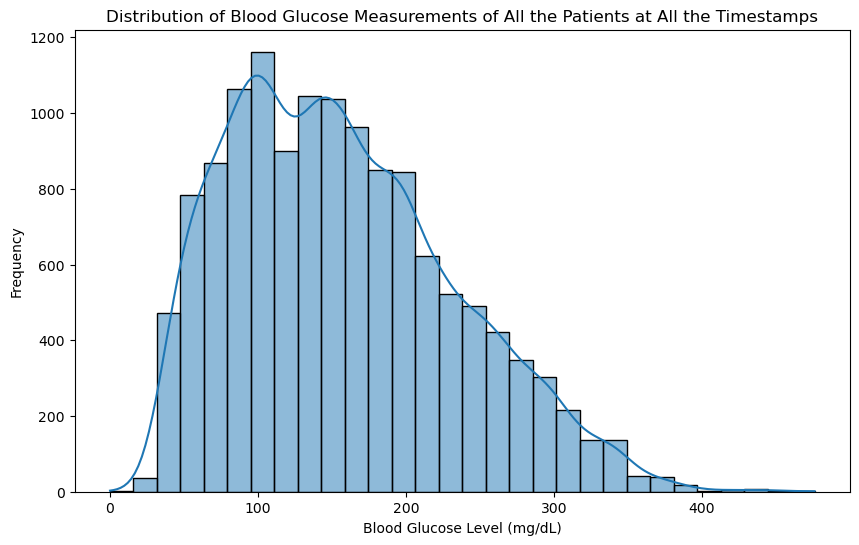

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 'Value' column contains blood glucose levels for the relevant 'Code' values
bg_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]  # Codes corresponding to blood glucose measurements

# Filter the DataFrame for blood glucose measurements
bg_data = patient_data_cleaned[patient_data_cleaned['Code'].isin(bg_codes)]

# Convert 'Value' to numeric, dropping non-numeric values (assuming they have been marked as NaNs)
bg_data['Value'] = pd.to_numeric(bg_data['Value'], errors='coerce').dropna()

# Compute summary statistics
summary_stats = bg_data['Value'].describe()
print(summary_stats)

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(bg_data['Value'], bins=30, kde=True)
plt.title('Distribution of Blood Glucose Measurements of All the Patients at All the Timestamps')
plt.xlabel('Blood Glucose Level (mg/dL)')
plt.ylabel('Frequency')
plt.show()





C:\Users\Faranak\AppData\Local\Temp\ipykernel_788\3326332799.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg_data['Value'] = pd.to_numeric(bg_data['Value'], errors='coerce').dropna()


count    13342.000000
mean       157.183481
std         75.992597
min          0.000000
25%         97.000000
50%        147.000000
75%        206.000000
max        476.000000
Name: Value, dtype: float64


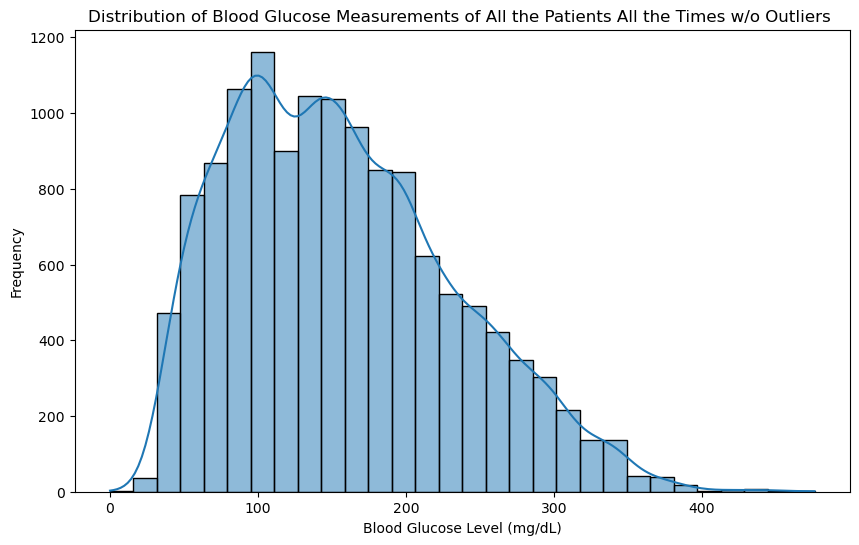

In [86]:
# 'Value' column contains blood glucose levels for the relevant 'Code' values
bg_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]  # Codes corresponding to blood glucose measurements

# Filter the DataFrame for blood glucose measurements
bg_data = data_without_outliers[data_without_outliers['Code'].isin(bg_codes)]

# Convert 'Value' to numeric, dropping non-numeric values (assuming they have been marked as NaNs)
bg_data['Value'] = pd.to_numeric(bg_data['Value'], errors='coerce').dropna()

# Compute summary statistics
summary_stats = bg_data['Value'].describe()
print(summary_stats)

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(bg_data['Value'], bins=30, kde=True)
plt.title('Distribution of Blood Glucose Measurements of All the Patients All the Times w/o Outliers ')
plt.xlabel('Blood Glucose Level (mg/dL)')
plt.ylabel('Frequency')
plt.show()



In [63]:
patient_data_cleaned.head()

,Date,Time,Code,Value,Patient_ID,Record_Type
Timestamp,,,,,,
1991-04-21 09:09:00,04-21-1991,9:09,58,100.0,01,Electronic
1991-04-21 09:09:00,04-21-1991,9:09,33,9.0,01,Electronic
1991-04-21 09:09:00,04-21-1991,9:09,34,13.0,01,Electronic
1991-04-21 17:08:00,04-21-1991,17:08,62,119.0,01,Electronic
1991-04-21 17:08:00,04-21-1991,17:08,33,7.0,01,Electronic


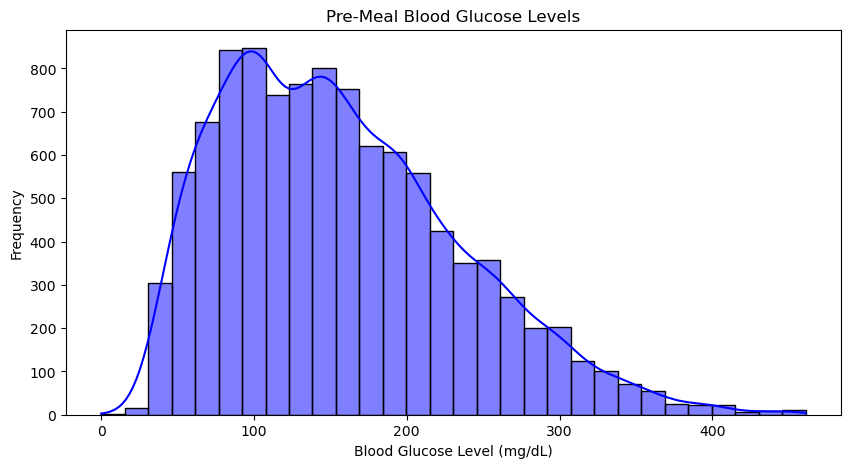

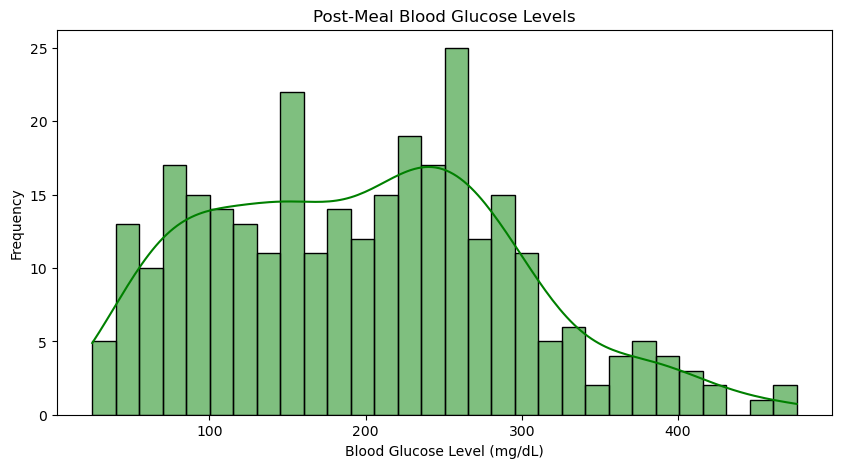

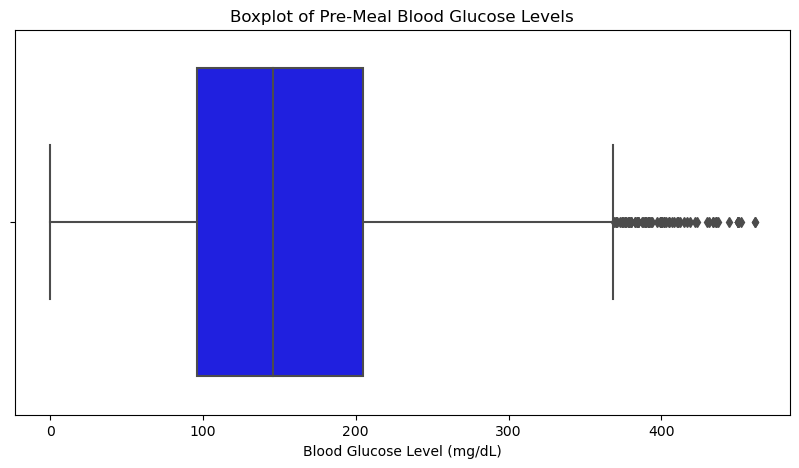

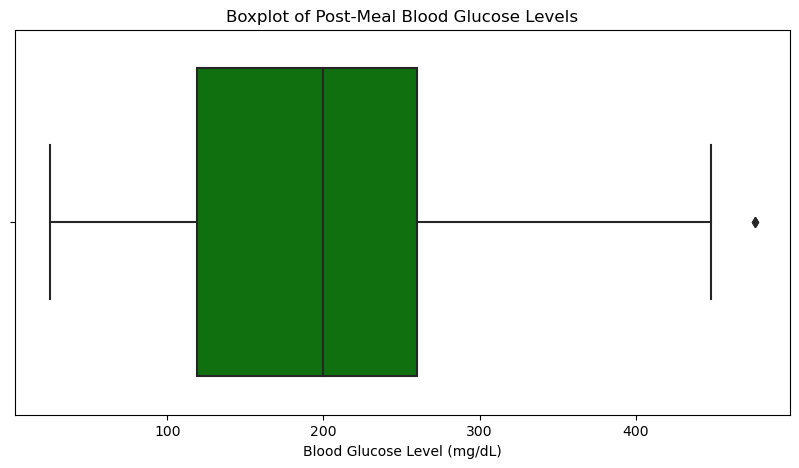

In [53]:
# Filter pre-meal and post-meal blood glucose levels
pre_meal_codes = [58, 60, 62, 64]  # Pre-meal codes
post_meal_codes = [59, 61, 63]     # Post-meal codes

pre_meal_data = patient_data_cleaned[patient_data_cleaned['Code'].isin(pre_meal_codes)]
post_meal_data = patient_data_cleaned[patient_data_cleaned['Code'].isin(post_meal_codes)]

# Plot histogram for pre-meal blood glucose levels
plt.figure(figsize=(10, 5))
sns.histplot(pre_meal_data['Value'], bins=30, kde=True, color='blue')
plt.title('Pre-Meal Blood Glucose Levels')
plt.xlabel('Blood Glucose Level (mg/dL)')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for post-meal blood glucose levels
plt.figure(figsize=(10, 5))
sns.histplot(post_meal_data['Value'], bins=30, kde=True, color='green')
plt.title('Post-Meal Blood Glucose Levels')
plt.xlabel('Blood Glucose Level (mg/dL)')
plt.ylabel('Frequency')
plt.show()

# Plot boxplot for pre-meal blood glucose levels
plt.figure(figsize=(10, 5))
sns.boxplot(x=pre_meal_data['Value'], color='blue')
plt.title('Boxplot of Pre-Meal Blood Glucose Levels')
plt.xlabel('Blood Glucose Level (mg/dL)')
plt.show()

# Plot boxplot for post-meal blood glucose levels
plt.figure(figsize=(10, 5))
sns.boxplot(x=post_meal_data['Value'], color='green')
plt.title('Boxplot of Post-Meal Blood Glucose Levels')
plt.xlabel('Blood Glucose Level (mg/dL)')
plt.show()

## Blood Glucose Trends over Time for each patient and average

C:\Users\Faranak\AppData\Local\Temp\ipykernel_788\2543957877.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg['Time'] = data_bg.index.time
C:\Users\Faranak\AppData\Local\Temp\ipykernel_788\2543957877.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg['Time_in_seconds'] = data_bg['Time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)


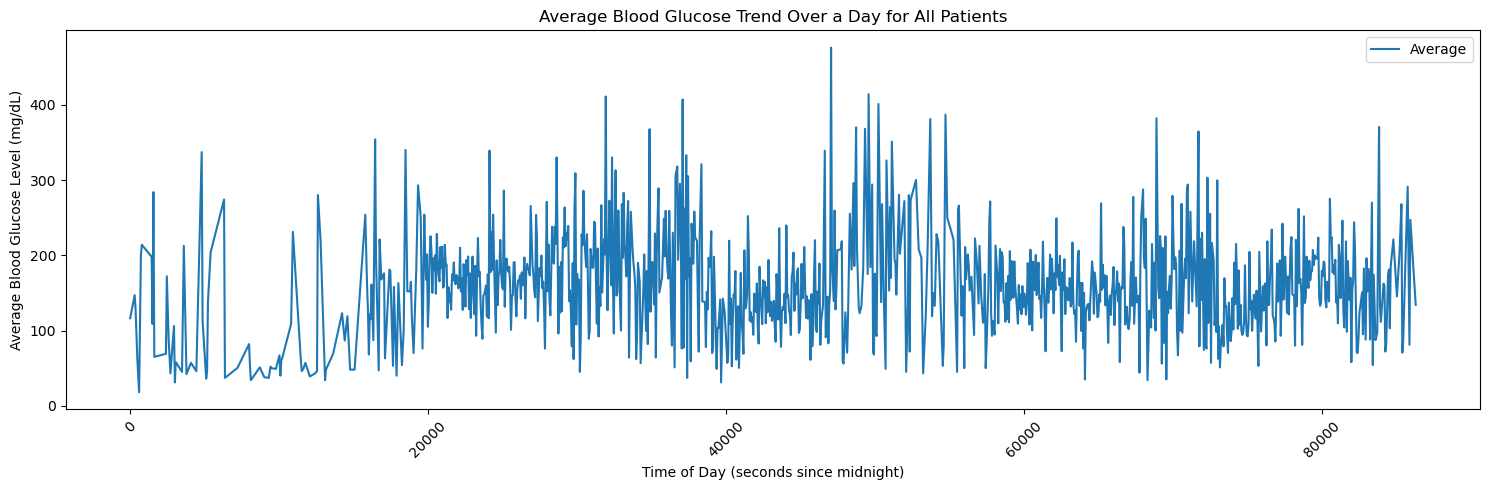

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Correct blood glucose measurement codes
bg_codes = [47, 57, 58, 59, 60, 61, 62, 63, 64]
data =patient_data_cleaned
# Filter the data for blood glucose measurement codes
data_bg = data[data['Code'].isin(bg_codes)]

# Convert time to seconds since midnight to plot
data_bg['Time'] = data_bg.index.time
data_bg['Time_in_seconds'] = data_bg['Time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

# Group by patient and time of day
grouped = data_bg.groupby(['Patient_ID', 'Time_in_seconds'])

# Calculate the mean for each group
time_of_day_means = grouped['Value'].mean().reset_index(name='Mean_BG')

# # Plot trends over a day for each patient
# unique_patients = time_of_day_means['Patient_ID'].unique()
# for patient in unique_patients:
#     patient_data = time_of_day_means[time_of_day_means['Patient_ID'] == patient]
#     plt.figure(figsize=(15, 5))
#     plt.plot(patient_data['Time_in_seconds'], patient_data['Mean_BG'], label=f'Patient {patient}')
#     plt.title(f'Blood Glucose Trend Over a Day for Patient {patient}')
#     plt.xlabel('Time of Day (seconds since midnight)')
#     plt.ylabel('Average Blood Glucose Level (mg/dL)')
#     plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#     plt.legend()
#     plt.tight_layout()  # Adjust layout
#     plt.show()

# Plot the average trend over a day for all patients
all_patients_data = time_of_day_means.groupby('Time_in_seconds')['Mean_BG'].mean().reset_index()
plt.figure(figsize=(15, 5))
plt.plot(all_patients_data['Time_in_seconds'], all_patients_data['Mean_BG'], label='Average')
plt.title('Average Blood Glucose Trend Over a Day for All Patients')
plt.xlabel('Time of Day (seconds since midnight)')
plt.ylabel('Average Blood Glucose Level (mg/dL)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout
plt.show()


more EDA

In [49]:
# Assuming 'patient_data_cleaned' is the DataFrame containing the cleaned data
code_hypoglycemia = 65

# Filter the DataFrame for rows where 'Code' is 65
hypoglycemia_rows = patient_data_cleaned[patient_data_cleaned['Code'] == code_hypoglycemia]

# Display the rows with original values for hypoglycemia events
print(hypoglycemia_rows[['Date', 'Time', 'Code', 'Value']])


             Date   Time  Code  Value
52     04-29-1991  12:00    65    0.0
65     04-30-1991  22:00    65    0.0
70     05-01-1991  12:00    65    0.0
79     05-02-1991  13:30    65    0.0
82     05-03-1991   3:00    65    0.0
...           ...    ...   ...    ...
27913  03-20-1991  16:30    65    0.0
28029  04-04-1991  11:30    65    0.0
28038  04-05-1991  11:35    65    0.0
28062  04-08-1991   9:30    65    0.0
28136  04-17-1991  10:30    65    0.0

[331 rows x 4 columns]


## Feature Extraction for Clustering the Patients

In [ ]:
import pandas as pd
from datetime import datetime

# Constants for codes
INSULIN_CODES = [33, 34, 35]
BG_MEASUREMENT_CODES = [48, 57, 58, 59, 60, 61, 62, 63, 64]
MEAL_CODES = [66, 67, 68]
EXERCISE_CODES = [69, 70, 71]
HYPO_SYMPTOMS_CODE = 65
SPECIAL_EVENT_CODE = 72

CODE_LABELS = {
    66: 'Typical_Meal',
    67: 'More_Than_Usual_Meal',
    68: 'Less_Than_Usual_Meal',
    69: 'Typical_Exercise',
    70: 'More_Than_Usual_Exercise',
    71: 'Less_Than_Usual_Exercise'
}

# Your existing DataFrame
# patient_data_cleaned = pd.read_csv('your_data.csv')  # Load your dataset if it's in a CSV file
# Ensure 'Date' is a datetime object
patient_data_cleaned['Date'] = pd.to_datetime(patient_data_cleaned['Date'])

# Feature extraction functions
def extract_insulin_dosage_features(df):
    insulin_df = df[df['Code'].isin(INSULIN_CODES)]
    daily_insulin = insulin_df.groupby(['Patient_ID', insulin_df['Date'].dt.date])['Value'].sum().reset_index(name='Total_Insulin')
    return daily_insulin

def extract_bg_features(df):
    bg_df = df[df['Code'].isin(BG_MEASUREMENT_CODES)]
    daily_bg_avg = bg_df.groupby(['Patient_ID', bg_df['Date'].dt.date])['Value'].mean().reset_index(name='Average_BG')
    return daily_bg_avg



def extract_hypo_event_features(df):
    hypo_df = df[df['Code'] == HYPO_SYMPTOMS_CODE]
    hypo_events = hypo_df.groupby(['Patient_ID', hypo_df['Date'].dt.date]).size().reset_index(name='Hypo_Events')
    return hypo_events

def extract_special_event_features(df):
    special_event_df = df[df['Code'] == SPECIAL_EVENT_CODE]
    special_events = special_event_df.groupby(['Patient_ID', special_event_df['Date'].dt.date]).size().reset_index(name='Special_Events')
    return special_events


# Define the mapping of codes to labels


def extract_diet_features(df):
    # Create separate features for each meal code
    diet_features = pd.DataFrame()
    for code, label in CODE_LABELS.items():
        if code in MEAL_CODES:
            meal_df = df[df['Code'] == code]
            meal_freq = meal_df.groupby(['Patient_ID', meal_df['Date'].dt.date]).size().reset_index(name=f'{label}')
            if diet_features.empty:
                diet_features = meal_freq
            else:
                diet_features = diet_features.merge(meal_freq, on=['Patient_ID', 'Date'], how='outer')
    return diet_features

def extract_exercise_features(df):
    # Create separate features for each exercise code
    exercise_features = pd.DataFrame()
    for code, label in CODE_LABELS.items():
        if code in EXERCISE_CODES:
            exercise_df = df[df['Code'] == code]
            exercise_freq = exercise_df.groupby(['Patient_ID', exercise_df['Date'].dt.date]).size().reset_index(name=f'{label}')
            if exercise_features.empty:
                exercise_features = exercise_freq
            else:
                exercise_features = exercise_features.merge(exercise_freq, on=['Patient_ID', 'Date'], how='outer')
    return exercise_features

# Later, when combining features:
# Combine all features into a single DataFrame
features_df = insulin_features.merge(bg_features, on=['Patient_ID', 'Date'], how='outer')
features_df = features_df.merge(diet_features, on=['Patient_ID', 'Date'], how='outer')
features_df = features_df.merge(exercise_features, on=['Patient_ID', 'Date'], how='outer')
features_df = features_df.merge(hypo_event_features, on=['Patient_ID', 'Date'], how='outer')
features_df = features_df.merge(special_event_features, on=['Patient_ID', 'Date'], how='outer')

# Fill NaN with 0 for count data
features_df.fillna(0, inplace=True)


## Insulin Response Clustering

C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


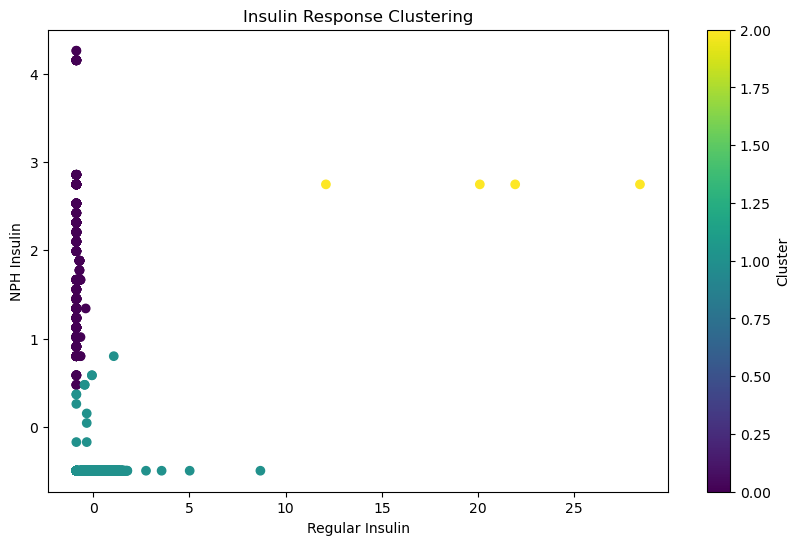

Code Patient_ID    33    34   35  Cluster
0            02  40.0   0.0  0.0        1
1            28  16.0  16.0  0.0        1
2            30  16.0  23.0  0.0        1
3            41  41.0   6.0  0.0        1
4            67  42.0  40.0  0.0        1
1    2835
0     787
2       4
Name: Cluster, dtype: int64


In [70]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define the insulin codes
INSULIN_CODES = [33, 34, 35]

# Filter out insulin dose records
insulin_data = patient_data_cleaned[patient_data_cleaned['Code'].isin(INSULIN_CODES)]

# Feature engineering: Summarize the total daily dosage for each type of insulin
insulin_features = insulin_data.pivot_table(index=['Date', 'Patient_ID'], columns='Code', values='Value', aggfunc='sum').fillna(0)

# Reset index to flatten the DataFrame
insulin_features.reset_index(inplace=True)

# Drop the 'Date' as it is not needed for clustering
insulin_features.drop('Date', axis=1, inplace=True)

# Normalize the features
scaler = StandardScaler()
insulin_scaled = scaler.fit_transform(insulin_features.iloc[:, 2:])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
insulin_features['Cluster'] = kmeans.fit_predict(insulin_scaled)

# Check the number of patients in each cluster
cluster_counts = insulin_features['Cluster'].value_counts()

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(insulin_scaled[:, 0], insulin_scaled[:, 1], c=insulin_features['Cluster'], cmap='viridis')
plt.title('Insulin Response Clustering')
plt.xlabel('Regular Insulin')
plt.ylabel('NPH Insulin')
plt.colorbar(label='Cluster')
plt.show()

# Print the head of the cluster assignment and counts
print(insulin_features.head())
print(cluster_counts)


C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

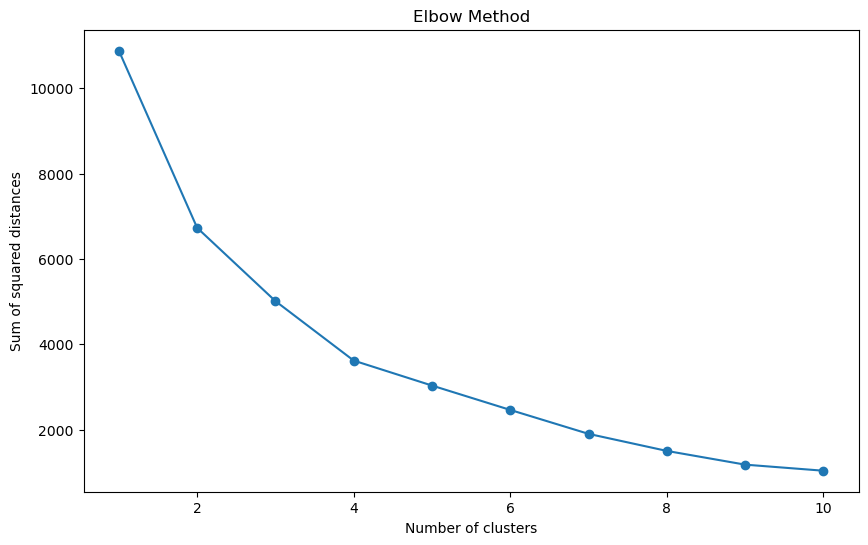

A bend in the plot typically indicates the optimal number of clusters.


In [74]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
## Data preprocessing 
# Summarize the total daily dosage for each type of insulin.

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Patient_data_cleaned is the DataFrame and 'Code' and 'Value' are the columns

# Filter out the rows corresponding to insulin dosages
insulin_data = patient_data_cleaned[patient_data_cleaned['Code'].isin([33, 34, 35])]

# Pivot the table to have separate columns for each type of insulin and sum the dosages per day per patient
daily_insulin = insulin_data.pivot_table(index=['Patient_ID', 'Date'], columns='Code', values='Value', aggfunc='sum').reset_index()

# Fill NaN values with 0, assuming no insulin taken is represented as NaN
daily_insulin.fillna(0, inplace=True)

# Rename the columns for clarity
daily_insulin.columns = ['Patient_ID', 'Date', 'Regular_Insulin', 'NPH_Insulin', 'UltraLente_Insulin']

# Feature Scaling
scaler = StandardScaler()
insulin_features = daily_insulin[['Regular_Insulin', 'NPH_Insulin', 'UltraLente_Insulin']]
insulin_features_scaled = scaler.fit_transform(insulin_features)


# Now insulin_features_scaled is a numpy array with normalized data.

## Here we use Elbow method to optimize number of clusters for K-Means
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming insulin_features_scaled is your normalized feature set
sse = []
for k in range(1, 11):  # Test for k values from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=0).fit(insulin_features_scaled)
    sse.append(kmeans.inertia_)  # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()
print("A bend in the plot typically indicates the optimal number of clusters.")


To find the optimal K for a dataset, we used the Elbow method; to find the point where the decrease in inertia begins to slow. **K=4 is the “elbow” of this graph.** 

C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


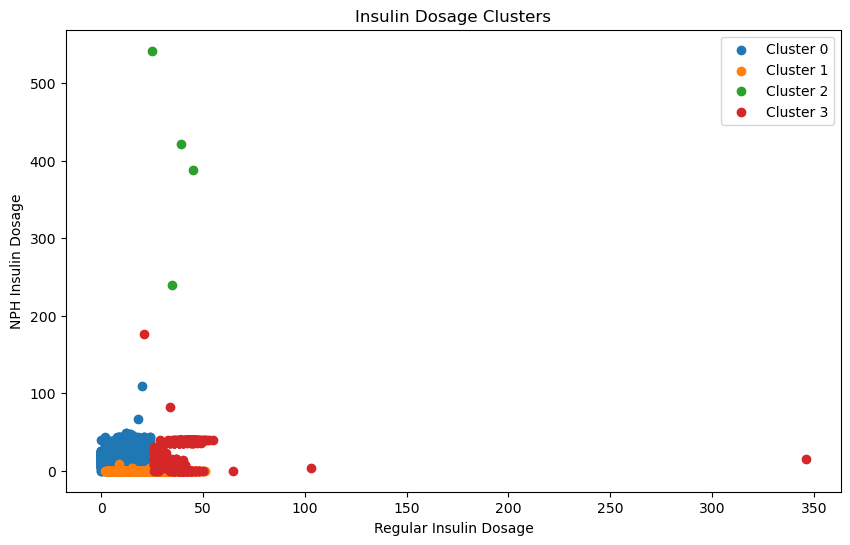

In [78]:
## now that optimal number of clusters is found, we continue with clustering and visualization

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming insulin_features_scaled is your normalized feature set
kmeans = KMeans(n_clusters=4, random_state=0).fit(insulin_features_scaled)

# Assign the cluster labels to the original dataframe
daily_insulin['Cluster'] = kmeans.labels_

# Now we have a 'Cluster' column in 'daily_insulin' DataFrame that shows the cluster each row belongs to

# Plotting each cluster to visualize
plt.figure(figsize=(10, 6))

# Set optimal_clusters based on elbow method result
optimal_clusters = 4

for cluster in range(optimal_clusters):
    # Filter the data for each cluster
    cluster_data = daily_insulin[daily_insulin['Cluster'] == cluster]
    
    #  'Regular_Insulin', 'NPH_Insulin', 'UltraLente_Insulin'  are the column names for insulin types and they represent insulin dosages
    plt.scatter(cluster_data['Regular_Insulin'], cluster_data['NPH_Insulin'], label=f'Cluster {cluster}')

plt.title('Insulin Dosage Clusters')
plt.xlabel('Regular Insulin Dosage')
plt.ylabel('NPH Insulin Dosage')
plt.legend()
plt.show()


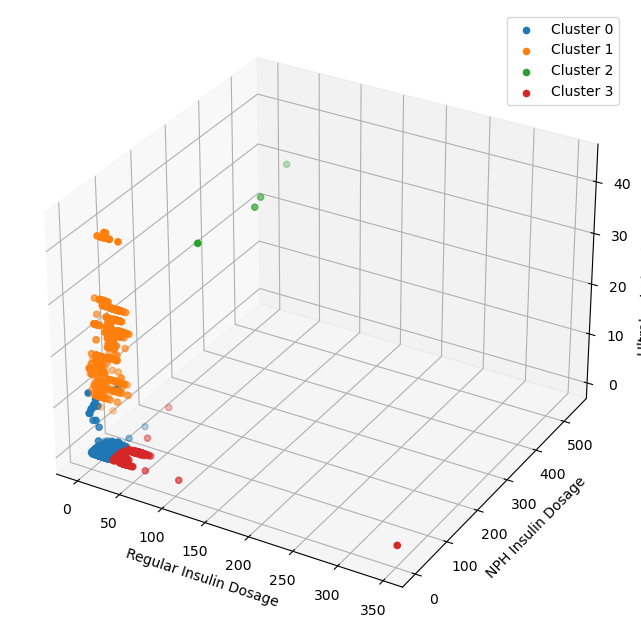

In [79]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3 insulin types
for cluster in range(4):
    cluster_data = daily_insulin[daily_insulin['Cluster'] == cluster]
    ax.scatter(cluster_data['Regular_Insulin'], cluster_data['NPH_Insulin'], cluster_data['UltraLente_Insulin'], label=f'Cluster {cluster}')

ax.set_xlabel('Regular Insulin Dosage')
ax.set_ylabel('NPH Insulin Dosage')
ax.set_zlabel('UltraLente Insulin Dosage')
ax.legend()
plt.show()


after visualizing the clusters we can see obvious **outliers** for NPH and Regular Insulin dosages that skews the clusters. Here we will take them out of the data set and run clustering again afterwards.

C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Faranak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


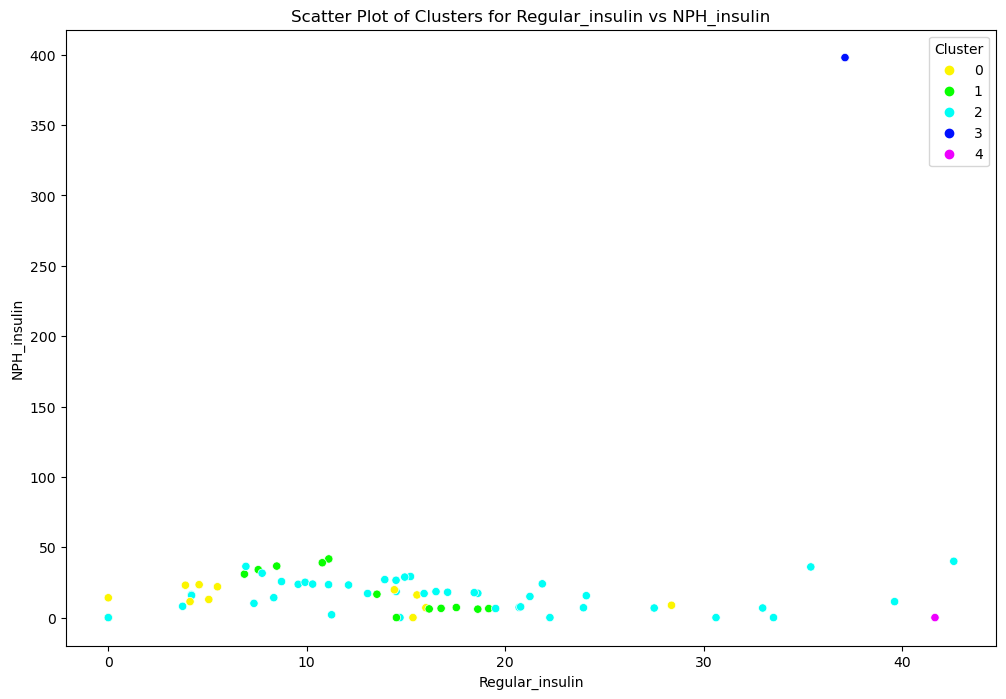

In [231]:

# Apply K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(patient_aggregated_features_standardized)

# Add the cluster labels to your original dataframe
patient_aggregated_features['Cluster'] = kmeans.labels_

# Select two features to plot - you can change these to other pairs
feature_1 = 'Regular_insulin'
feature_2 = 'NPH_insulin'

# Custom palette with distinct colors for each cluster
palette = sns.color_palette("hsv", 5)  # 'hsv' is a color space, and 6 is the number of distinct colors

# Create a scatter plot with the custom palette
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=patient_aggregated_features,
    x=feature_1,
    y=feature_2,
    hue='Cluster',
    palette=palette,
    legend='full'
)
plt.title(f'Scatter Plot of Clusters for {feature_1} vs {feature_2}')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.legend(title='Cluster')
plt.show()
